# Ingeniería de Características para Modelado Predictivo

El notebook presente tiene como objetivo transformar el dataset limpio (`data/processed/global_energy_consumption_clean.csv`) mediante la creación de nuevas características que capturen relaciones complejas, mejoren la capacidad predictiva y faciliten la interpretabilidad.

## 1. Configuraciones del Entorno de Trabajo y Rutas

* Importación de Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler

* Importación de Funciones Personalizadas

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import src.ingenieria_caracteristicas as ic
import src.preprocesamiento as pre
import src.visualizacion as vis

* Configuración Global

In [3]:
# Configración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

# Configuración de Scikit-learn
rscaler = RobustScaler()

* Rutas

In [ ]:
raw_path = os.path.join('..', 'data', 'original', 'global_energy_consumption.csv')
data_path = os.path.join('..', 'data', 'procesados', 'global_energy_consumption_clean.csv')
output_data = os.path.join('..', 'data', 'procesados', 'global_energy_consumption_features.csv')

* Cargando Base de Datos Limpia

In [5]:
df = pre.cargar_datos(data_path)

* Inspección Inicial

In [6]:
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (10000, 20)


In [7]:
print("\nTipos de datos:\n", df.dtypes)


Tipos de datos:
 Country                             object
Year                                 int64
Total Energy Consumption (TWh)     float64
Per Capita Energy Use (kWh)        float64
Renewable Energy Share (%)         float64
Fossil Fuel Dependency (%)         float64
Carbon Emissions (Million Tons)    float64
Energy Price Index (USD/kWh)       float64
Industrial Energy Use (%)          float64
Household Energy Use (%)           float64
Country_Australia                  float64
Country_Brazil                     float64
Country_Canada                     float64
Country_China                      float64
Country_Germany                    float64
Country_India                      float64
Country_Japan                      float64
Country_Russia                     float64
Country_UK                         float64
Country_USA                        float64
dtype: object


In [8]:
print("\nPrimeras filas:\n", df.head())


Primeras filas:
    Country  Year  Total Energy Consumption (TWh)  Per Capita Energy Use (kWh)  \
0   Canada  2018                            1.54                         1.22   
1  Germany  2020                            0.98                         0.81   
2   Russia  2002                            0.52                         1.17   
3   Brazil  2010                            1.21                        -0.99   
4   Canada  2006                           -1.51                         0.50   

   Renewable Energy Share (%)  Fossil Fuel Dependency (%)  \
0                       -1.37                        1.26   
1                       -0.56                       -0.15   
2                       -1.48                       -0.28   
3                        1.05                       -1.40   
4                        1.07                        1.48   

   Carbon Emissions (Million Tons)  Energy Price Index (USD/kWh)  \
0                             0.86                         -

In [9]:
print("\nValores faltantes:\n", df.isnull().sum())


Valores faltantes:
 Country                            0
Year                               0
Total Energy Consumption (TWh)     0
Per Capita Energy Use (kWh)        0
Renewable Energy Share (%)         0
Fossil Fuel Dependency (%)         0
Carbon Emissions (Million Tons)    0
Energy Price Index (USD/kWh)       0
Industrial Energy Use (%)          0
Household Energy Use (%)           0
Country_Australia                  0
Country_Brazil                     0
Country_Canada                     0
Country_China                      0
Country_Germany                    0
Country_India                      0
Country_Japan                      0
Country_Russia                     0
Country_UK                         0
Country_USA                        0
dtype: int64


In [10]:
print("\nFilas duplicadas:", df.duplicated().sum())


Filas duplicadas: 0


## 2. Generación de Características: Tasas de Crecimiento, Ratios Energéticos y Variables Temporales

### 2.1. Creación de Tasas de Crecimiento Anual

En esta sub-sección se pretende carcular tasas de crecimiento anual para variables clave, agrupadas por país. Lo que permite capturar la dinámica de crecimiento de cada país en el período analizado.

In [11]:
# Ordenar el dataset por 'Country' y 'Year'
df = df.sort_values(['Country', 'Year'])

# Calcular tasas de crecimiento anual para variables seleccionadas
columnas_tasa_anual = ['Total Energy Consumption (TWh)', 'Per Capita Energy Use (kWh)', 'Carbon Emissions (Million Tons)']

for col in columnas_tasa_anual:
    df[f"Tasa Anual {col}"] = df.groupby('Country')[col].pct_change() * 100

# Imputar valores faltantes en tasas de crecimiento con 0
col_tasa_anual = [f"Tasa Anual {col}" for col in columnas_tasa_anual]
df[col_tasa_anual] = df[col_tasa_anual].fillna(0)

# Verificar nuevas columnas
df[col_tasa_anual].head(10)

,Tasa Anual Total Energy Consumption (TWh),Tasa Anual Per Capita Energy Use (kWh),Tasa Anual Carbon Emissions (Million Tons)
108,0.00,0.00,0.00
554,-254.75,34.27,851.22
729,42.13,-78.99,-183.40
1027,54.62,-128.79,22.60
1420,59.31,"-1,769.78",-142.25
1500,3.51,-120.42,54.24
1538,10.23,"1,020.10",-56.53
1599,-3.95,-153.91,-290.41
1605,-67.13,76.52,-167.12
1711,-142.30,10.79,69.94


### 2.2. Creación de Ratios Energéticos

Se calculan los ratios que representen relaciones entre variables energéticas, con lo que se pretende evaluar el progreso, identificar patrones y fundamentar desiciones respecto de los diferentes grupos de paises que se formaran en este estudio.

In [12]:
# Ratio renovables vs. fósiles (Composición de la matriz energética)
df['renewable_fossil_ratio'] = df['Renewable Energy Share (%)'] / df['Fossil Fuel Dependency (%)']

# Eficiencia energética (Eficiencia de la matriz energética)
df['energy_efficiency'] = df['Total Energy Consumption (TWh)'] / df['Carbon Emissions (Million Tons)']

# Dependencia de combustibles fósiles (Participación fósil sobre total renovable + fósil)
df['fossil_total_ratio'] = df['Fossil Fuel Dependency (%)'] / (df['Fossil Fuel Dependency (%)'] + df['Renewable Energy Share (%)'])

# Costos de las emisiones de carbono (Precio de la energía sobre emisiones de carbono)
df['price_emissions_ratio'] = df['Energy Price Index (USD/kWh)'] / df['Carbon Emissions (Million Tons)']

df[['renewable_fossil_ratio', 'energy_efficiency', 'fossil_total_ratio', 'price_emissions_ratio']].head(10)

,renewable_fossil_ratio,energy_efficiency,fossil_total_ratio,price_emissions_ratio
108,2.19,1.53,0.31,-5.47
554,0.40,-0.25,0.71,0.17
729,0.28,0.42,0.78,-0.60
1027,-0.00,0.53,1.00,0.52
1420,-0.68,-2.01,3.12,1.04
1500,-137.57,-1.35,-0.01,0.74
1538,-0.66,-3.42,2.91,1.71
1599,-1.42,1.73,-2.38,-1.24
1605,-3.50,-0.85,-0.40,0.59
1711,0.93,0.21,0.52,-1.06


## 3. Visualización de las Nuevas Características 

Dado que se han generado nuevas columnas con las caracteristicas del dataset original, se puede visualizar la información de las nuevas columnas para entender mejor la información que se ha generado.

In [13]:
columnas = ['renewable_fossil_ratio', 'energy_efficiency', 'fossil_total_ratio', 'price_emissions_ratio']

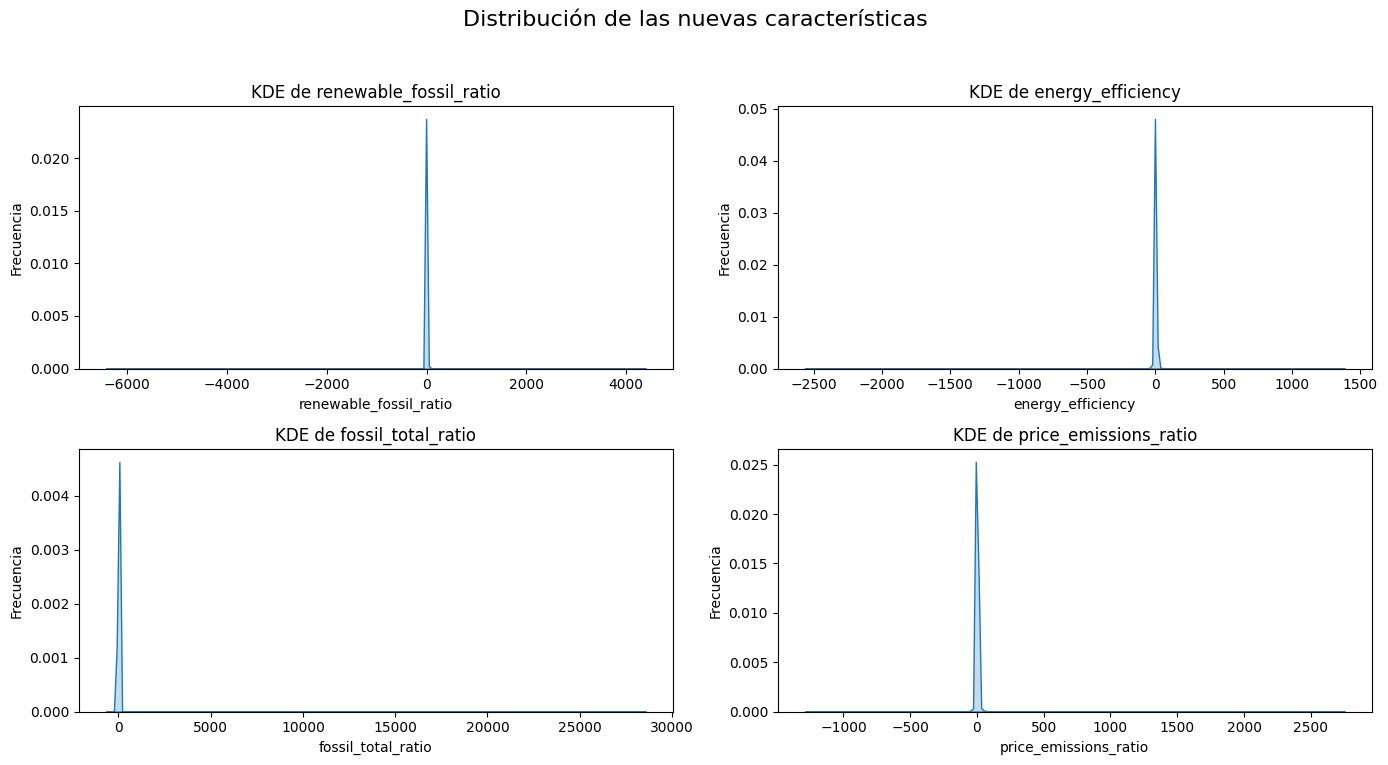

In [14]:
vis.crear_kde_multiples(df, columnas, "Distribución de las nuevas características")

In [15]:
for col in df.columns[0:26+1]:
    minimo = df[col].min()
    maximo = df[col].max()
    print(f"Máximo/mínimo de {col}: {maximo} / {minimo}")

Máximo/mínimo de Country: USA / Australia
Máximo/mínimo de Year: 2024 / 2000
Máximo/mínimo de Total Energy Consumption (TWh): 1.7049342835524928 / -1.7700147073246515
Máximo/mínimo de Per Capita Energy Use (kWh): 1.7564033150618568 / -1.7275444315494264
Máximo/mínimo de Renewable Energy Share (%): 1.734661580688255 / -1.7202667235242917
Máximo/mínimo de Fossil Fuel Dependency (%): 1.7358436965306894 / -1.728700863969023
Máximo/mínimo de Carbon Emissions (Million Tons): 1.729728528184555 / -1.745399513702884
Máximo/mínimo de Energy Price Index (USD/kWh): 1.7322349959823284 / -1.7087749548067266
Máximo/mínimo de Industrial Energy Use (%): 1.7283848852121548 / -1.7383665292221655
Máximo/mínimo de Household Energy Use (%): 1.7398412971130552 / -1.749912727227302
Máximo/mínimo de Country_Australia: 1.0 / 0.0
Máximo/mínimo de Country_Brazil: 1.0 / 0.0
Máximo/mínimo de Country_Canada: 1.0 / 0.0
Máximo/mínimo de Country_China: 1.0 / 0.0
Máximo/mínimo de Country_Germany: 1.0 / 0.0
Máximo/mínimo

In [16]:
vis.crear_box_plot_interactivo(df, 'Country', columnas, 'Año', 'Metricas_derivadas')

**Hallazgo Clave:** 

Tal como se evidencia en ambas gráficas [Gráfica de cajas y bigotes de las métricas derivadas](../outputs/html/grafico_lineas_interactivo_Metricas_derivadas_.html) y [Gráfica KDE de métricas derivadas](../outputs/figuras/kdes_Distribución%20de%20las%20nuevas%20características_.png) existen mucho outliers en las nuevas métricas, por lo que se hace necesario aplicar técnicas de escalado de datos un poco más avanzadas como `RobustScaler` para visualizar mejor los datos y evitar que los outliers afecten el entrenamiento del modelo.

## 4. Estandarización y Normalización de Variables.

* Aplicar RobustScaler a Métricas Derivadas

In [17]:
columnas_nuevas = ['Tasa Anual Total Energy Consumption (TWh)', 'Tasa Anual Per Capita Energy Use (kWh)', 
            'Tasa Anual Carbon Emissions (Million Tons)', 'renewable_fossil_ratio', 'energy_efficiency', 
            'fossil_total_ratio', 'price_emissions_ratio']

df_base = df[columnas_nuevas].copy()

df_escalados = pre.estandarizacion(df_base, columnas_nuevas,rscaler)

* Combinar con el DataFrame Limpio

In [18]:
df = pre.combinar_df(df, df_escalados, columnas_nuevas)

for col in df.columns[0:26+1]:
    minimo = df[col].min()
    maximo = df[col].max()
    print(f"Máximo/mínimo de {col}: {maximo} / {minimo}")

Máximo/mínimo de Country: USA / Australia
Máximo/mínimo de Year: 2024 / 2000
Máximo/mínimo de Total Energy Consumption (TWh): 1.7049342835524928 / -1.7700147073246515
Máximo/mínimo de Per Capita Energy Use (kWh): 1.7564033150618568 / -1.7275444315494264
Máximo/mínimo de Renewable Energy Share (%): 1.734661580688255 / -1.7202667235242917
Máximo/mínimo de Fossil Fuel Dependency (%): 1.7358436965306894 / -1.728700863969023
Máximo/mínimo de Carbon Emissions (Million Tons): 1.729728528184555 / -1.745399513702884
Máximo/mínimo de Energy Price Index (USD/kWh): 1.7322349959823284 / -1.7087749548067266
Máximo/mínimo de Industrial Energy Use (%): 1.7283848852121548 / -1.7383665292221655
Máximo/mínimo de Household Energy Use (%): 1.7398412971130552 / -1.749912727227302
Máximo/mínimo de Country_Australia: 1.0 / 0.0
Máximo/mínimo de Country_Brazil: 1.0 / 0.0
Máximo/mínimo de Country_Canada: 1.0 / 0.0
Máximo/mínimo de Country_China: 1.0 / 0.0
Máximo/mínimo de Country_Germany: 1.0 / 0.0
Máximo/mínimo

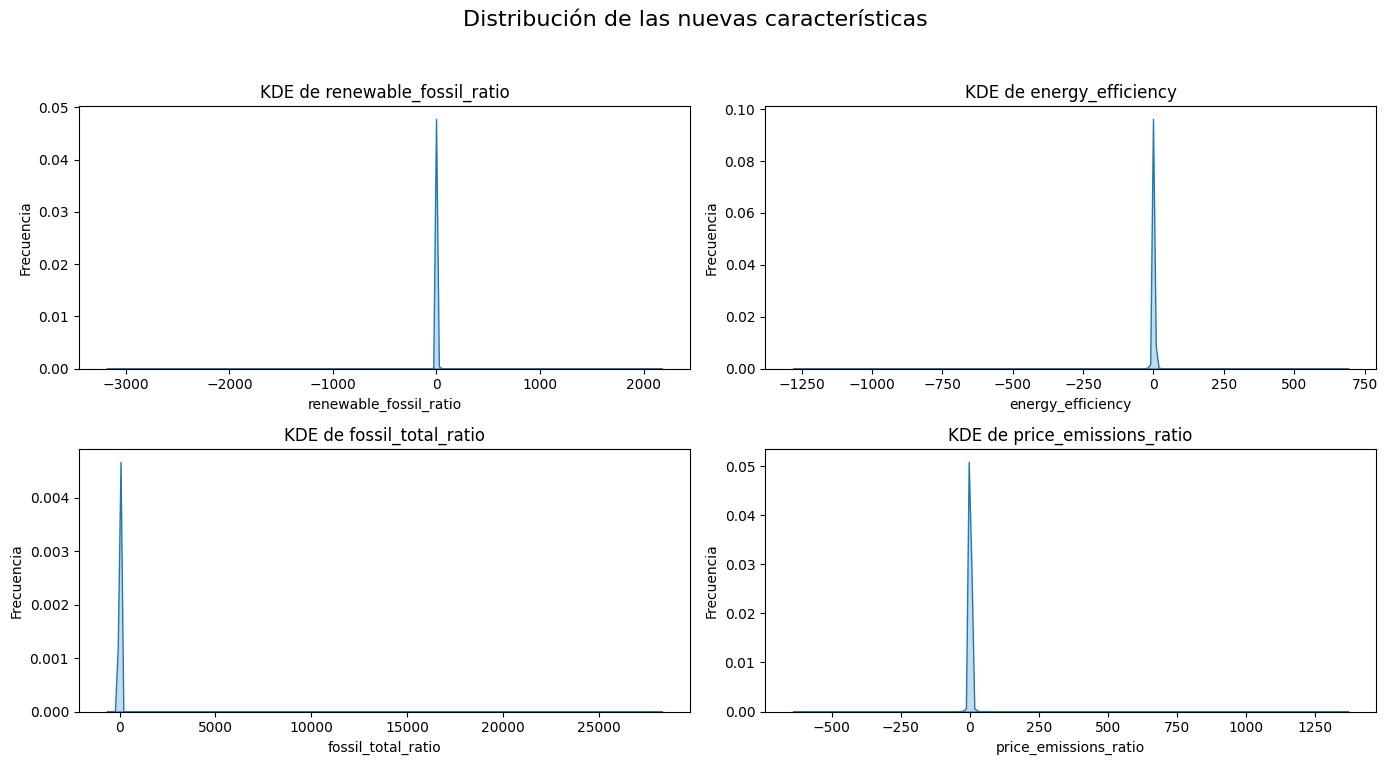

In [19]:
vis.crear_kde_multiples(df, columnas, "Distribución de las nuevas características")